In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Pytorch DATALOADER and DATASETS

In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform= None):
        self.data = ImageFolder(data_dir, transform = transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
dataset = PlayingCardDataset(data_dir = "/kaggle/input/cards-image-datasetclassification/train")

In [4]:
pic = dataset.__getitem__(0)
pic[1]

0

In [5]:
data_dir = "/kaggle/input/cards-image-datasetclassification/train"
target_to_class = {v:k for k,v in ImageFolder(data_dir).class_to_idx.items()}  ## for mapping labels to its meaning ##
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [6]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [7]:
dataset = PlayingCardDataset(data_dir ="/kaggle/input/cards-image-datasetclassification/train", transform = transform)

In [8]:
dataset[0][0].shape

torch.Size([3, 128, 128])

In [9]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [10]:
## Creating a Pytorch Model ##

In [11]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes = 53):
        super(SimpleCardClassifier, self).__init__()
        
        self.base_model = timm.create_model('efficientnet_b0', pretrained = True)
        enet_out_size = 1280
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        self.classifier = nn.Linear(enet_out_size, num_classes)
        
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output
    

In [12]:
model = SimpleCardClassifier(num_classes = 53)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [13]:
## Training LOOPS 

In [14]:
train_folder = "/kaggle/input/cards-image-datasetclassification/train" 
test_folder = "/kaggle/input/cards-image-datasetclassification/test"
valid_folder = "/kaggle/input/cards-image-datasetclassification/valid"

train_dataset = PlayingCardDataset(data_dir = train_folder, transform = transform)
test_dataset = PlayingCardDataset(data_dir = test_folder, transform = transform)
valid_dataset = PlayingCardDataset(data_dir = valid_folder, transform = transform)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle =True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle =False)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle= False)


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
num_epochs = 10
train_losses, valid_losses = [], []

model = SimpleCardClassifier(num_classes = 53)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
for epoch in range(num_epochs):
    ## Training Phase ##
    model.train()
    running_loss = 0.0
    for inputs , labels in tqdm(train_loader, desc = "Trainig loop"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss/ len(train_loader)
    train_losses.append(train_loss)
    
    ## Validation phase ##
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc ="Validation loop"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
    valid_loss = running_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    print(f"Epochs {epoch} / {num_epochs} - Train loss:{train_loss}, Validation loss:{valid_loss}")

Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 0 / 10 - Train loss:51.697735766486645, Validation loss:14.22564803229438


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 1 / 10 - Train loss:18.138610538578433, Validation loss:7.091346025466919


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 2 / 10 - Train loss:10.780898767036375, Validation loss:6.012012428707546


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 3 / 10 - Train loss:7.654412911028044, Validation loss:4.726681816081206


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 4 / 10 - Train loss:5.951313692281436, Validation loss:3.4404543572001987


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 5 / 10 - Train loss:5.482130990242858, Validation loss:4.600625640816158


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 6 / 10 - Train loss:4.8087402747390655, Validation loss:4.759584897404744


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 7 / 10 - Train loss:5.078365989216452, Validation loss:4.545128133561876


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 8 / 10 - Train loss:3.6081183825202565, Validation loss:2.6792961654977665


Trainig loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epochs 9 / 10 - Train loss:2.499402131269604, Validation loss:1.781364505774238


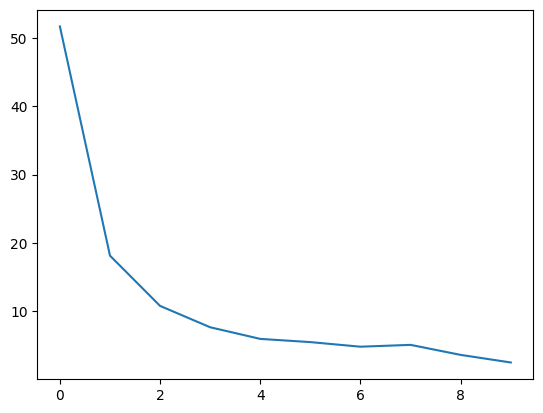

In [17]:
plt.plot(train_losses)

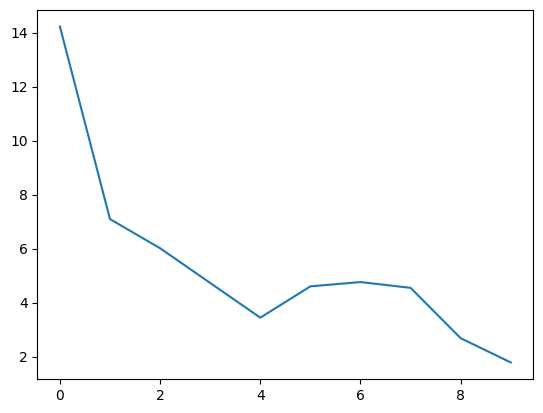

In [18]:
plt.plot(valid_losses)